<a href="https://colab.research.google.com/github/badaroz/rnn/blob/main/local_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import struct
from array import array
from os.path  import join

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        


In [3]:
input_path = '/content/drive/MyDrive/IFES/mnist'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(train_images, train_labels), (test_images, test_labels) = mnist_dataloader.load_data()

In [4]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [5]:
train_images.shape, len(train_labels), train_labels

((60000, 28, 28), 60000, array([5, 0, 4, ..., 5, 6, 8], dtype=uint8))

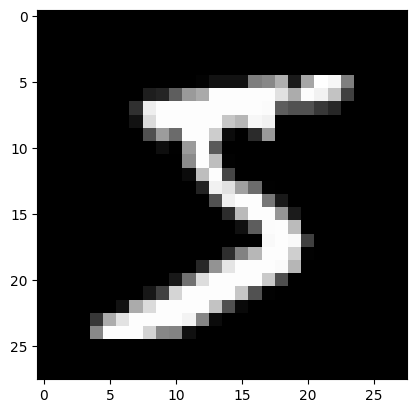

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_images[0], cmap='gray')
plt.show()

In [7]:
test_images.shape, len(test_labels), test_labels

((10000, 28, 28), 10000, array([7, 2, 1, ..., 4, 5, 6], dtype=uint8))

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [9]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [10]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

In [11]:
(train_images.shape, train_labels), (test_images.shape, test_labels)

(((60000, 784), array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)),
 ((10000, 784), array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)))

In [12]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 7s 13ms/step - loss: 0.2663 - accuracy: 0.9245
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1078 - accuracy: 0.9683
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0701 - accuracy: 0.9798
Epoch 4/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0513 - accuracy: 0.9845
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0382 - accuracy: 0.9886


In [13]:
predicted = model.predict(test_images[0:1])
predicted[0]

1/1 [==============================] - 0s 87ms/step


array([1.02469095e-07, 2.78684809e-08, 9.64116261e-05, 1.51435123e-03,
       1.31822164e-10, 1.33864376e-06, 9.87656051e-12, 9.98373985e-01,
       3.63768322e-06, 1.02213480e-05], dtype=float32)

In [14]:
predicted[0].argmax()

7

In [15]:
predicted[0][7]

0.998374

In [16]:
test_labels[0]

7

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0637 - accuracy: 0.9795
test_acc: 0.9794999957084656


In [18]:
from tensorflow.keras.utils import to_categorical
train_labels_hot = to_categorical(train_labels)
test_labels_hot = to_categorical(test_labels)

In [19]:
from keras.utils.sidecar_evaluator import optimizer
from prompt_toolkit.shortcuts.progress_bar.base import E
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import numpy as np

class RedeNeural(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128):
    self.epochs = epochs
    self.batch_size = batch_size
  def fit(self, X, y):
    self.model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(y.shape[1], activation="softmax")
    ])
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size)
    return self
  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    return np.array([(a == np.max(a)) for a in probabilities])

modelo = RedeNeural()
modelo.fit(train_images, train_labels_hot)
ypred = modelo.predict(test_images)
accuracy_score(test_labels_hot, ypred)

Epoch 1/5
469/469 [==============================] - 7s 13ms/step - loss: 0.2664 - accuracy: 0.9241
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1089 - accuracy: 0.9677
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0707 - accuracy: 0.9789
Epoch 4/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0520 - accuracy: 0.9838
Epoch 5/5
313/313 [==============================] - 1s 2ms/step


0.9801

In [20]:
from keras.utils.sidecar_evaluator import optimizer
from prompt_toolkit.shortcuts.progress_bar.base import E
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import numpy as np

class RedeNeural(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128):
    self.epochs = epochs
    self.batch_size = batch_size

  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(yhot.shape[1], activation="softmax")
    ])
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, yhot, epochs=self.epochs, batch_size=self.batch_size)
    return self

  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    ypred = self.labels[np.argmax(probabilities, axis=1)]
    return ypred

modelo = RedeNeural()
modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 [==============================] - 7s 13ms/step - loss: 0.2638 - accuracy: 0.9237
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1064 - accuracy: 0.9688
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0705 - accuracy: 0.9790
Epoch 4/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0501 - accuracy: 0.9852
Epoch 5/5
313/313 [==============================] - 1s 2ms/step


0.9787

In [21]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(train_images, train_labels), (test_images, test_labels) = mnist_dataloader.load_data()

In [23]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [24]:
train_images = train_images.reshape((60000, 28 * 28))
test_images = test_images.reshape((10000, 28 * 28))

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

modelo = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("ann", RedeNeural())
])
modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 [==============================] - 7s 14ms/step - loss: 0.2620 - accuracy: 0.9247
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1068 - accuracy: 0.9685
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0695 - accuracy: 0.9797
Epoch 4/5
469/469 [==============================] - 6s 13ms/step - loss: 0.0502 - accuracy: 0.9843
Epoch 5/5
313/313 [==============================] - 1s 2ms/step


0.9786

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin

class DividePor255(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    return X.astype("float32") / 255

from sklearn.pipeline import Pipeline

modelo = Pipeline([
    ("scaler", DividePor255()), 
    ("ann", RedeNeural())
])
modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 [==============================] - 5s 10ms/step - loss: 0.2628 - accuracy: 0.9241
Epoch 2/5
469/469 [==============================] - 6s 12ms/step - loss: 0.1067 - accuracy: 0.9684
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0701 - accuracy: 0.9790
Epoch 4/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0509 - accuracy: 0.9852
Epoch 5/5
313/313 [==============================] - 1s 2ms/step


0.9788

In [27]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(train_images, train_labels), (test_images, test_labels) = mnist_dataloader.load_data()

In [28]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [29]:
from keras.utils.sidecar_evaluator import optimizer
from prompt_toolkit.shortcuts.progress_bar.base import E
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import numpy as np

class RedeNeural(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128):
    self.epochs = epochs
    self.batch_size = batch_size

  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = keras.Sequential([
        layers.Conv2D(4, 4, activation='relu'),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(yhot.shape[1], activation="softmax")
    ])
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, yhot, epochs=self.epochs, batch_size=self.batch_size)
    return self

  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    ypred = self.labels[np.argmax(probabilities, axis=1)]
    return ypred

class MudaShape(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    return X.reshape((-1,28,28,1))

modelo = Pipeline([
    ("scaler", DividePor255()), 
    ("reshape", MudaShape()), 
    ("ann", RedeNeural())
])
modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 [==============================] - 31s 66ms/step - loss: 0.2196 - accuracy: 0.9341
Epoch 2/5
469/469 [==============================] - 31s 66ms/step - loss: 0.0706 - accuracy: 0.9783
Epoch 3/5
469/469 [==============================] - 32s 69ms/step - loss: 0.0430 - accuracy: 0.9869
Epoch 4/5
469/469 [==============================] - 32s 67ms/step - loss: 0.0283 - accuracy: 0.9913
Epoch 5/5
313/313 [==============================] - 3s 9ms/step


0.9823